In [16]:
%pip install selenium beautifulsoup4 nltk matplotlib wordcloud selenium

Note: you may need to restart the kernel to use updated packages.


In [17]:
import re
import json
import nltk
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from concurrent.futures import ThreadPoolExecutor, as_completed

# Ensure NLTK data path
nltk.data.path.append('./nltk_data')

# Download necessary NLTK data if not already available
nltk.download('stopwords', download_dir='./nltk_data')
nltk.download('punkt', download_dir='./nltk_data')

STOPWORDS = set(stopwords.words('english')).union({
    "new", "says", "world", "week", "first", "market", "day", "year", "latest", "today", 
    "next", "live", "say", "years", "watch", "breaking", "art", "report", "get", "via", 
    "one", "article", "story", "news", "post", "now", "will", "also", "just", "like", 
    "even", "back", "going", "still", "time", "know", "think", "see", "may", "top", "off", 
    "time", "dont", "please", "help", "thank", "about", "before", "youre", "would", "way"
})


PUNCTUATION = set(['.', ',', '!', '?', ':', ';', '-', '’', '“', '”', '…'])

print("First 10 stopwords:", stopwords.words('english')[:10])

First 10 stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to ./nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to ./nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
# Define categories and associated URLs
CATEGORIES = {
    "World": [
        "https://x.com/CNN", 
        "https://x.com/Reuters", "https://x.com/AP", "https://x.com/BBCWorld",
        "https://x.com/NBCNews", "https://x.com/NYTimesWorld", "https://x.com/AFP", 
        "https://x.com/guardian", "https://x.com/abcnews", "https://x.com/CTVNews", "https://x.com/NewsHour",
        "https://x.com/globaltimesnews", "https://x.com/RT_com", "https://x.com/europarl_EN", 
        "https://x.com/BreakingNews", "https://x.com/SkyNews",
        "https://x.com/thedailybeast", "https://x.com/time"
    ],
    "Business": [
        "https://x.com/WSJ", 
        "https://x.com/federalreserve", "https://x.com/Business", 
        "https://x.com/FinancialTimes", "https://x.com/CNBC", "https://x.com/Bloomberg", 
        "https://x.com/businessinsider", "https://x.com/MarketWatch", "https://x.com/economics",
        "https://x.com/forbes", "https://x.com/TheEconomist", "https://x.com/YahooFinance",
        "https://x.com/smallbiztrends", "https://x.com/NASDAQ", "https://x.com/SPGlobal",
        "https://x.com/SchwabResearch", "https://x.com/WSJMarkets", "https://x.com/morningstarinc",
        "https://x.com/IBDinvestors"
    ],
    "Music": [
        "https://x.com/billboard", "https://x.com/rollingstone", "https://x.com/NME", "https://x.com/pitchfork",
        "https://x.com/MusicWeek", "https://x.com/ComplexMusic", "https://x.com/MTV",
        "https://x.com/BBCR1", "https://x.com/BET", "https://x.com/AppleMusic",
        "https://x.com/rapradar", "https://x.com/soundcloud", 
        "https://x.com/popjustice", "https://x.com/AltPress", "https://x.com/classicfm",
        "https://x.com/HotNewHipHop", "https://x.com/SONGKICK", "https://x.com/officialcharts"
    ],
    "Technology": [
        "https://x.com/verge", "https://x.com/wired", "https://x.com/TechCrunch", "https://x.com/gizmodo",
        "https://x.com/engadget", "https://x.com/CNET", "https://x.com/zdnet", "https://x.com/arstechnica",
        "https://x.com/mashable", "https://x.com/digitaltrends", "https://x.com/recode",
        "https://x.com/VentureBeat", "https://x.com/thenextweb", "https://x.com/slashdot",
        "https://x.com/macrumors", "https://x.com/androidcentral",
        "https://x.com/9to5mac", "https://x.com/PCMag"
    ],
    "Games": [
        "https://x.com/IGN", "https://x.com/GameSpot", "https://x.com/Kotaku",
        "https://x.com/TheVerge", "https://x.com/Polygon", "https://x.com/GamesRadar", "https://x.com/PCGamer",
        "https://x.com/Shacknews", "https://x.com/Destructoid",
        "https://x.com/PlayStation", "https://x.com/Xbox", "https://x.com/Nintendo", "https://x.com/Steam",
        "https://x.com/Blizzard_Ent", 
    ],
    "Arts": [
        "https://x.com/ArtForum", "https://x.com/TheArtNewspaper", "https://x.com/DesignBoom", "https://x.com/Hyperallergic",
        "https://x.com/Artnet", "https://x.com/ArtBasel", "https://x.com/ArtNet",
        "https://x.com/ArtSpace", "https://x.com/DesignMuseum", "https://x.com/BrooklynMuseum", "https://x.com/Sothebys",
    ],
}

In [ ]:

def init_driver(headless=True):
    options = Options()
    if headless:
        options.add_argument("--headless")
        options.add_argument("--disable-gpu")
        options.add_argument("--no-sandbox")
    return webdriver.Chrome(options=options)

def scroll_and_scrape(driver, max_scrolls=10):
    tweets = []
    seen_texts = set()

    for _ in range(max_scrolls):
        driver.execute_script("window.scrollBy(0, 300);")
        time.sleep(1)

        soup = BeautifulSoup(driver.page_source, 'html.parser')
        for tweet in soup.find_all('article'):
            text = tweet.find(['div', 'span'], {'data-testid': 'tweetText'})
            if text and text.get_text() not in seen_texts:
                tweets.append(text.get_text())
                seen_texts.add(text.get_text())

    return tweets

def scrape_account(url, headless=True, max_retries=5):
    driver = init_driver(headless)
    driver.get(url)

    tweets = []
    retries = 0

    while retries < max_retries and not tweets:
        try:
            WebDriverWait(driver, 5).until(
                EC.presence_of_element_located((By.XPATH, "//div[@data-testid='tweetText']"))
            )
            tweets = scroll_and_scrape(driver)
        except Exception as e:
            # print(f"Retry {retries + 1}/{max_retries} - Waiting for tweets...")
            retries += 1
            time.sleep(2)

    driver.quit()
    if tweets:
        print(f"Collected {len(tweets)} tweets from {url}.")
    else:
        print(f"Failed to collect tweets from {url} after {max_retries} retries.")
    
    return tweets

def scrape_multiple_accounts(urls, headless=True, max_retries=8):
    unique_urls = list(set(urls))  # Remove duplicate URLs if any
    all_tweets_set = set()  # Store unique tweets only

    with ThreadPoolExecutor(max_workers=20) as executor:
        future_to_url = {executor.submit(scrape_account, url, headless, max_retries): url for url in unique_urls}

        for future in as_completed(future_to_url):
            url = future_to_url[future]
            try:
                tweets = future.result()
                all_tweets_set.update(tweets)  # Add tweets to set for uniqueness
            except Exception as exc:
                print(f"Exception occurred while scraping {url}: {exc}")

    return list(all_tweets_set)  # Convert set to list for final output

In [20]:
def select_category():
    print("Available categories:")
    for i, category in enumerate(CATEGORIES, 1):
        print(f"{i}. {category}")

    # Prompt user for multiple category numbers, separated by commas
    choice = input("Select categories by number, 1. World 2. Business 3. Music 4. Technology 5. Games 6. Arts: ")

    # Split the input and convert to integers, then adjust for zero-based index
    selected_indices = [int(x.strip()) - 1 for x in choice.split(",")]

    # Get the corresponding category names
    selected_categories = [list(CATEGORIES.keys())[i] for i in selected_indices]

    # Get the URLs for the selected categories
    selected_urls = []
    for category in selected_categories:
        selected_urls.extend(CATEGORIES[category])

    return selected_categories, selected_urls

In [21]:
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    words = text.lower().split()
    return [word for word in words if word not in STOPWORDS and word not in PUNCTUATION]

In [22]:
if __name__ == "__main__":
    # Select categories and URLs
    category, urls = select_category()
    print(f"Scraping tweets for category: {category}")

    # Scrape multiple accounts concurrently
    all_tweets = scrape_multiple_accounts(urls, headless=True)
    print(f"\nTotal unique tweets collected: {len(all_tweets)}\n")

    # Get the current time and format it for the filename (e.g., '2024-11-15_13-45-30')
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    
    # Create a filename using the category and timestamp (e.g., 'World_2024-11-15_13-45-30.json')
    json_filename = f"./data/{category}_{timestamp}.json"

    # Save unique tweets to the JSON file with the category and timestamped filename
    with open(json_filename, "w", encoding="utf-8") as file:
        json.dump(all_tweets, file, ensure_ascii=False, indent=2)
    print(f"All unique tweets for category '{category}' have been saved to {json_filename}")


Available categories:
1. World
2. Business
3. Music
4. Technology
5. Games
6. Arts
Scraping tweets for category: ['World']
Collected 10 tweets from https://x.com/RT_com.
Collected 12 tweets from https://x.com/Reuters.
Collected 11 tweets from https://x.com/globaltimesnews.
Collected 12 tweets from https://x.com/time.
Collected 10 tweets from https://x.com/europarl_EN.
Collected 14 tweets from https://x.com/BreakingNews.
Collected 13 tweets from https://x.com/CTVNews.
Collected 12 tweets from https://x.com/NYTimesWorld.
Collected 13 tweets from https://x.com/BBCWorld.
Collected 9 tweets from https://x.com/SkyNews.
Collected 11 tweets from https://x.com/NewsHour.
Collected 12 tweets from https://x.com/AFP.
Collected 12 tweets from https://x.com/CNN.
Collected 13 tweets from https://x.com/guardian.
Collected 13 tweets from https://x.com/thedailybeast.
Collected 14 tweets from https://x.com/abcnews.
Collected 12 tweets from https://x.com/NBCNews.
Failed to collect tweets from https://x.com

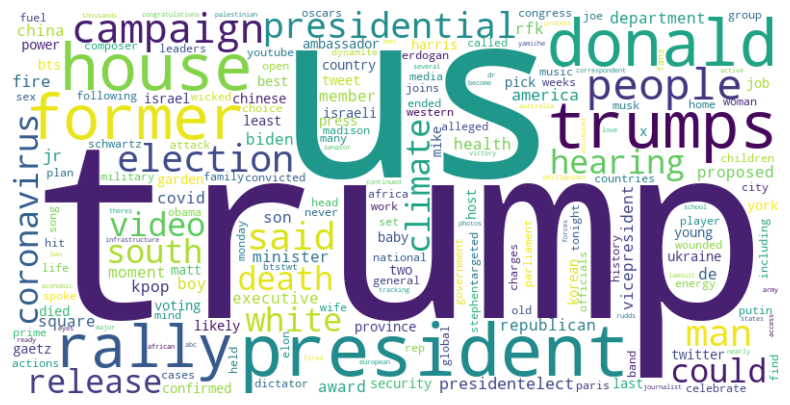

In [23]:
# Preprocess all the tweets and remove stopwords
processed_tweets = []
for tweet in all_tweets:
    words = preprocess_text(tweet)
    filtered_words = [word for word in words if word not in STOPWORDS]
    processed_tweets.append(filtered_words)

all_text = " ".join([" ".join(tweet) for tweet in processed_tweets])  # Join each tweet's words
word_freq = Counter(all_text.split())  # Count the frequency of each word

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

wordcloud_filename = f"./image/{category}_{timestamp}_wordcloud.png"
wordcloud.to_file(wordcloud_filename)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Top Keywords: [('trump', 23), ('us', 21), ('president', 14), ('house', 11), ('trumps', 11), ('donald', 11), ('former', 10), ('rally', 9), ('people', 8), ('campaign', 8)]


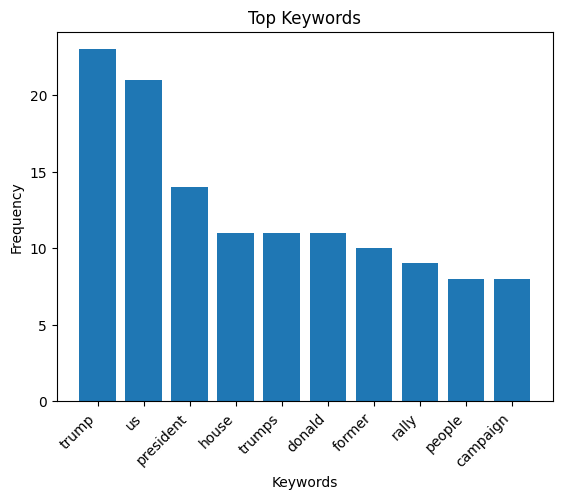

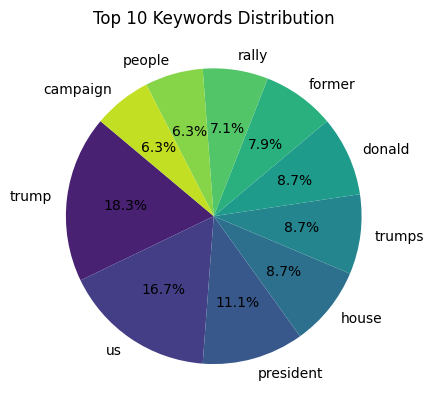

In [24]:
# Extract keywords (top_n most common words)
def extract_keywords(texts, top_n):
    all_words = []
    for text in texts:
        all_words.extend(text)  # Flatten the list of lists
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

# Extract top 10 keywords
keywords = extract_keywords(processed_tweets, top_n=10)
print("Top Keywords:", keywords)

# Generate bar plot
def generate_bar_plot(keywords):
    words, frequencies = zip(*keywords)

    plt.bar(words, frequencies)
    plt.xlabel('Keywords')
    plt.ylabel('Frequency')
    plt.title('Top Keywords')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Generate pie chart
def generate_pie_chart(keywords, top_n=10):
    keywords = sorted(keywords, key=lambda x: x[1], reverse=True)[:top_n]
    words, frequencies = zip(*keywords)

    plt.pie(frequencies, labels=words, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(words)))
    plt.title(f'Top {top_n} Keywords Distribution')
    plt.show()

generate_bar_plot(keywords)
generate_pie_chart(keywords)
